In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch.nn.functional as F

pd.set_option('display.max_columns', None)

In [3]:
supervector_df = pd.read_csv(r'D:\Mémoire\Mémoire\Projet\ellipsometry\results\20250415_2316\supervector_maxwell_garnett.csv')
print("Supervector DataFrame :")
supervector_df.head()

Supervector DataFrame :


,psi,delta,wavelength,thickness,vfraction
0,33.891845,11.307751,361.5,0.0,0.01
1,33.215410,6.206663,372.8,0.0,0.01
2,31.951873,3.982396,381.3,0.0,0.01
3,30.713691,2.896009,391.0,0.0,0.01
4,29.759814,2.353519,400.8,0.0,0.01


In [4]:
grouped = supervector_df.groupby(['vfraction', 'thickness'])[['psi', 'delta']].apply(
    lambda x: x.values.flatten()
).reset_index()

grouped.columns = ['vfraction', 'thickness', 'psi_delta_flatten']

print("\nGrouped and Flattened Supervector DataFrame :")
grouped.head()


Grouped and Flattened Supervector DataFrame :


,vfraction,thickness,psi_delta_flatten
0,0.01,0.0,"[33.89184524229016, 11.30775096669899, 33.2154..."
1,0.01,1.0,"[33.90873916907706, 12.870013017310855, 33.217..."
2,0.01,2.0,"[33.93049720169222, 14.425754274769847, 33.225..."
3,0.01,3.0,"[33.95710039828774, 15.973852126189136, 33.237..."
4,0.01,4.0,"[33.98852936625691, 17.513190660599545, 33.253..."


In [5]:
X = np.stack(grouped['psi_delta_flatten'].values)
y = grouped[['thickness', 'vfraction']].values

print("Dimensions des entrées (X) :", X.shape)
print("Dimensions des sorties (y) :", y.shape)

Dimensions des entrées (X) : (18030, 90)
Dimensions des sorties (y) : (18030, 2)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
from sklearn.preprocessing import MinMaxScaler  # remplacer StandardScaler

scaler_X = StandardScaler()  # Tu peux garder StandardScaler pour X si X contient des spectres
scaler_y = MinMaxScaler()    # Remplacer ici pour garder les y dans une plage positive

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


Epoch [50/500], Loss: 0.1272
Epoch [100/500], Loss: 0.0866
Epoch [150/500], Loss: 0.0788
Epoch [200/500], Loss: 0.0745
Epoch [250/500], Loss: 0.0719
Epoch [300/500], Loss: 0.0702
Epoch [350/500], Loss: 0.0691
Epoch [400/500], Loss: 0.0683
Epoch [450/500], Loss: 0.0676
Epoch [500/500], Loss: 0.0671

Performance sur le test set:
| Variable   |            MSE |       RMSE |        MAE |       R² |   Max Error |
|:-----------|---------------:|-----------:|-----------:|---------:|------------:|
| thickness  | 2301.39        | 47.9728    | 40.1673    | 0.922212 |  259.462    |
| vfraction  |    0.000272502 |  0.0165076 |  0.0107143 | 0.962942 |    0.141899 |


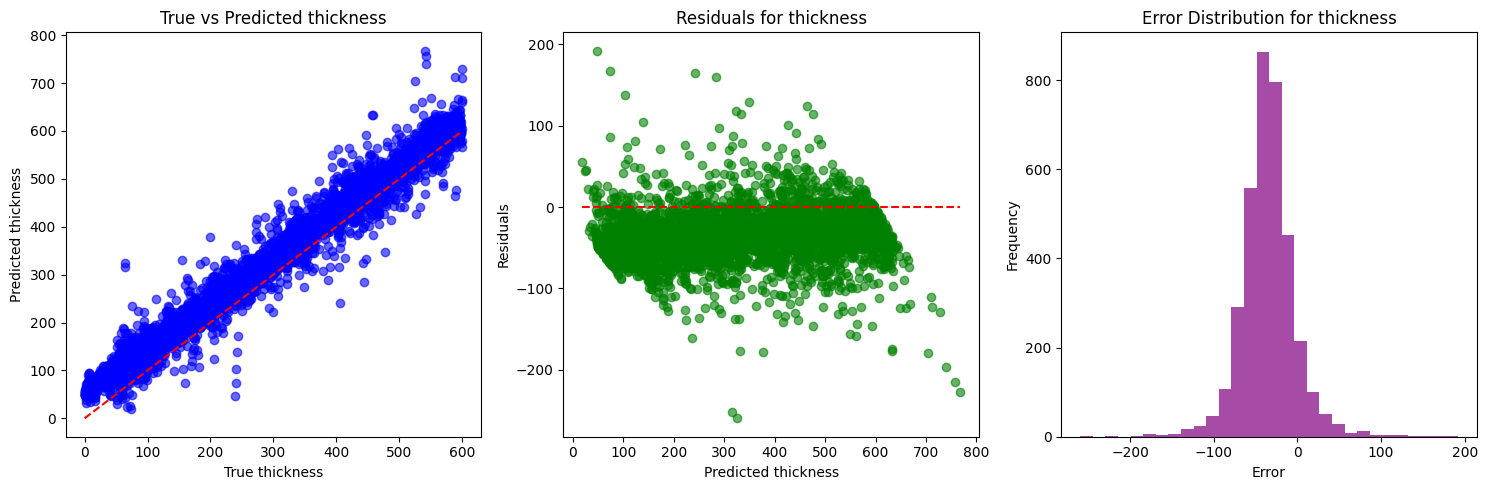

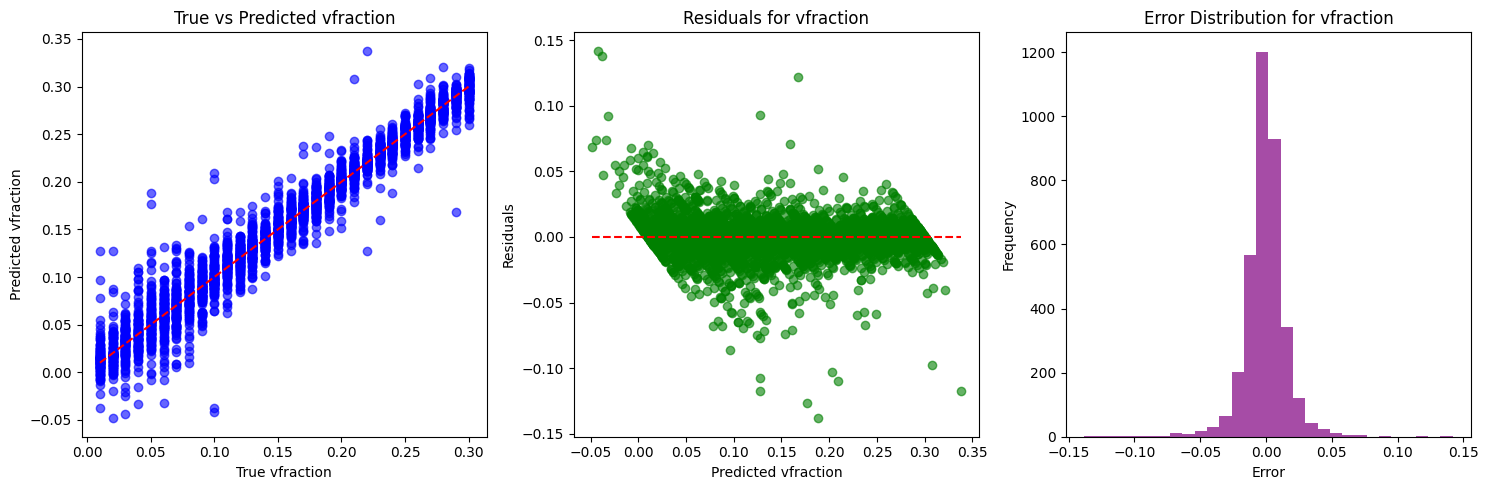

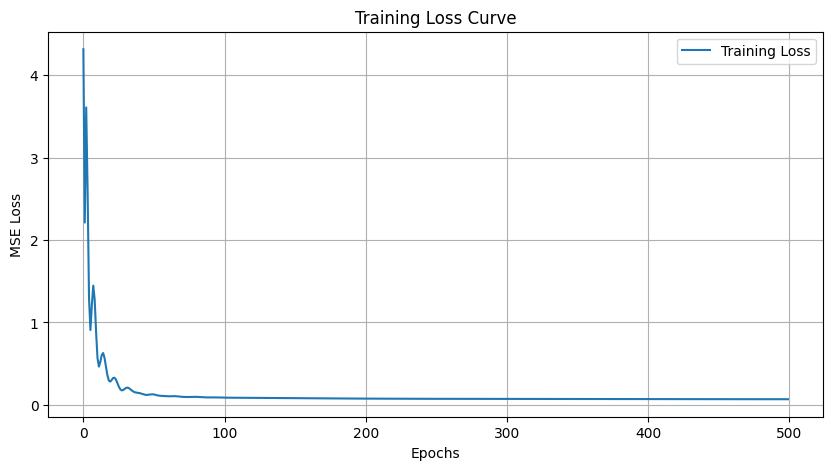

In [8]:
class NeuralNetwork(nn.Module):
    """Réseau de neurones feed-forward avec 3 couches cachées et LeakyReLU"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.hidden1 = nn.Linear(input_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.hidden3 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.leaky_relu = nn.LeakyReLU(0.1)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                nn.init.constant_(m.bias, 0.1)

    def forward(self, x):
        x = self.leaky_relu(self.hidden1(x))
        x = self.leaky_relu(self.hidden2(x))
        x = self.leaky_relu(self.hidden3(x))
        x = self.output(x)
        return x
        
# Hyperparamètres
input_dim = X_train.shape[1]
hidden_dim = 250             
output_dim = y_train.shape[1]  
learning_rate = 0.001
num_epochs = 500

class PositiveMSELoss(nn.Module):
    """Fonction de perte pénalisant les prédictions négatives"""
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, input, target):
        # Pénalité exponentielle pour les valeurs négatives
        thickness_penalty = torch.exp(-input[:, 0]).mean()
        vfraction_penalty = (input[:, 1] < 0).float().mean() + (input[:, 1] > 1).float().mean()
        
        return self.mse(input, target) + 0.1 * thickness_penalty + 0.1 * vfraction_penalty


# Initialisation
model = NeuralNetwork(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # L2 regularization
criterion = PositiveMSELoss()

# Entraînement avec early stopping
best_loss = float('inf')
patience = 20
trigger_times = 0
loss_history = []


for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    
    loss_history.append(epoch_loss)
    
    # Early stopping logic
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Évaluation
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_tensor).numpy()
    y_pred_test = model(X_test_tensor).numpy()

# Inversion de la normalisation
y_pred_test = scaler_y.inverse_transform(y_pred_test)
y_test_orig = scaler_y.inverse_transform(y_test)
y_pred_train = scaler_y.inverse_transform(y_pred_train)
y_train_orig = scaler_y.inverse_transform(y_train)


# Métriques complètes
def calculate_metrics(true, pred, label):
    return {
        'Variable': label,
        'MSE': mean_squared_error(true, pred),
        'RMSE': np.sqrt(mean_squared_error(true, pred)),
        'MAE': mean_absolute_error(true, pred),
        'R²': r2_score(true, pred),
        'Max Error': np.max(np.abs(true - pred))
    }

metrics = []
for i, label in enumerate(['thickness', 'vfraction']):
    metrics.append(calculate_metrics(y_test_orig[:, i], y_pred_test[:, i], label))

metrics_df = pd.DataFrame(metrics)
print("\nPerformance sur le test set:")
print(metrics_df.to_markdown(index=False))

# Visualisation améliorée
def plot_results_complete(true, pred, label):
    plt.figure(figsize=(15, 5))
    
    # Scatter plot
    plt.subplot(1, 3, 1)
    plt.scatter(true, pred, alpha=0.6, color='b')
    plt.plot([true.min(), true.max()], [true.min(), true.max()], 'r--')
    plt.xlabel(f"True {label}")
    plt.ylabel(f"Predicted {label}")
    plt.title(f"True vs Predicted {label}")
    
    # Residual plot
    plt.subplot(1, 3, 2)
    residuals = true - pred
    plt.scatter(pred, residuals, alpha=0.6, color='g')
    plt.hlines(0, pred.min(), pred.max(), colors='r', linestyles='dashed')
    plt.xlabel(f"Predicted {label}")
    plt.ylabel("Residuals")
    plt.title(f"Residuals for {label}")
    
    # Error distribution
    plt.subplot(1, 3, 3)
    plt.hist(residuals, bins=30, color='purple', alpha=0.7)
    plt.xlabel("Error")
    plt.ylabel("Frequency")
    plt.title(f"Error Distribution for {label}")
    
    plt.tight_layout()
    plt.show()

for i, label in enumerate(['thickness', 'vfraction']):
    plot_results_complete(y_test_orig[:, i], y_pred_test[:, i], label)

# Courbe d'apprentissage
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid()
plt.show()

Recherche par grille

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product

# Définition de l'architecture du modèle (identique à la vôtre)
class NeuralNetwork(nn.Module):
    """Réseau de neurones feed-forward avec 3 couches cachées et LeakyReLU"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.hidden1 = nn.Linear(input_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.hidden3 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.leaky_relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.leaky_relu(self.hidden1(x))
        x = self.leaky_relu(self.hidden2(x))
        x = self.leaky_relu(self.hidden3(x))
        x = self.output(x)
        return x

# Fonction d'entraînement avec early stopping
def train_model(X_train_tensor, y_train_tensor, X_test_tensor, y_test, 
               input_dim, output_dim, hidden_dim, learning_rate, 
               num_epochs=1000, patience=20):
    
    model = NeuralNetwork(input_dim, hidden_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    best_loss = float('inf')
    trigger_times = 0
    loss_history = []
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        
        epoch_loss = loss.item()
        loss_history.append(epoch_loss)
        
        # Early stopping logic
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                break
    
    # Évaluation du modèle
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test_tensor).numpy()
    
    # Inversion de la normalisation
    y_pred_test = scaler_y.inverse_transform(y_pred_test)
    y_test_orig = scaler_y.inverse_transform(y_test)
    
    # Calcul des métriques
    metrics = []
    for i, label in enumerate(['thickness', 'vfraction']):
        metrics.append({
            'hidden_dim': hidden_dim,
            'learning_rate': learning_rate,
            'Variable': label,
            'MSE': mean_squared_error(y_test_orig[:, i], y_pred_test[:, i]),
            'RMSE': np.sqrt(mean_squared_error(y_test_orig[:, i], y_pred_test[:, i])),
            'MAE': mean_absolute_error(y_test_orig[:, i], y_pred_test[:, i]),
            'R²': r2_score(y_test_orig[:, i], y_pred_test[:, i]),
            'Max Error': np.max(np.abs(y_test_orig[:, i] - y_pred_test[:, i])),
            'Epochs': epoch + 1,
            'Final Loss': epoch_loss
        })
    
    return metrics, loss_history

# Définition de la grille d'hyperparamètres
param_grid = {
    'hidden_dim': [100, 120, 150, 180, 200, 220, 250],
    'learning_rate': [0.001, 0.0005, 0.0001]
}
input_dim = X_train.shape[1]            
output_dim = y_train.shape[1]  
num_epochs = 1000

# Recherche par grille
all_metrics = []
all_loss_histories = {}

for params in product(*param_grid.values()):
    hidden_dim, learning_rate = params
    print(f"\nTraining with hidden_dim={hidden_dim}, learning_rate={learning_rate}")
    
    metrics, loss_history = train_model(
        X_train_tensor, y_train_tensor, X_test_tensor, y_test,
        input_dim, output_dim, hidden_dim, learning_rate
    )
    
    all_metrics.extend(metrics)
    all_loss_histories[(hidden_dim, learning_rate)] = loss_history

# Création d'un DataFrame avec tous les résultats
results_df = pd.DataFrame(all_metrics)

NameError: name 'param_grid' is not defined

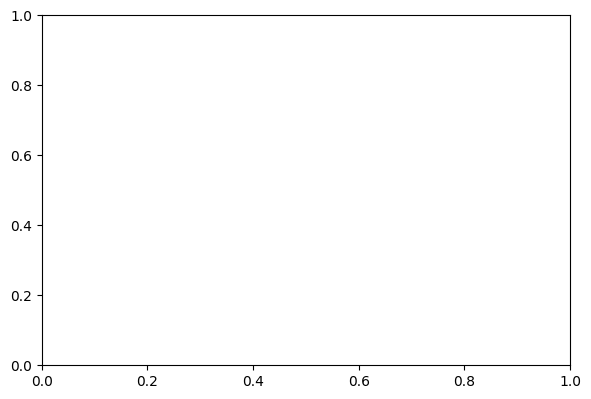

In [9]:
# 1. Visualisation des métriques par combinaison d'hyperparamètres
plt.figure(figsize=(15, 10))

# RMSE pour thickness
plt.subplot(2, 2, 1)
for lr in param_grid['learning_rate']:
    subset = results_df[(results_df['Variable'] == 'thickness') & 
                      (results_df['learning_rate'] == lr)]
    plt.plot(subset['hidden_dim'], subset['RMSE'], 'o-', label=f'lr={lr}')
plt.xlabel('Hidden Dimension')
plt.ylabel('RMSE')
plt.title('RMSE for Thickness Prediction')
plt.legend()
plt.grid()

# RMSE pour vfraction
plt.subplot(2, 2, 2)
for lr in param_grid['learning_rate']:
    subset = results_df[(results_df['Variable'] == 'vfraction') & 
                      (results_df['learning_rate'] == lr)]
    plt.plot(subset['hidden_dim'], subset['RMSE'], 'o-', label=f'lr={lr}')
plt.xlabel('Hidden Dimension')
plt.ylabel('RMSE')
plt.title('RMSE for Vfraction Prediction')
plt.legend()
plt.grid()

# R² pour thickness
plt.subplot(2, 2, 3)
for lr in param_grid['learning_rate']:
    subset = results_df[(results_df['Variable'] == 'thickness') & 
                      (results_df['learning_rate'] == lr)]
    plt.plot(subset['hidden_dim'], subset['R²'], 'o-', label=f'lr={lr}')
plt.xlabel('Hidden Dimension')
plt.ylabel('R² Score')
plt.title('R² Score for Thickness Prediction')
plt.legend()
plt.grid()

# R² pour vfraction
plt.subplot(2, 2, 4)
for lr in param_grid['learning_rate']:
    subset = results_df[(results_df['Variable'] == 'vfraction') & 
                      (results_df['learning_rate'] == lr)]
    plt.plot(subset['hidden_dim'], subset['R²'], 'o-', label=f'lr={lr}')
plt.xlabel('Hidden Dimension')
plt.ylabel('R² Score')
plt.title('R² Score for Vfraction Prediction')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# 2. Courbes d'apprentissage comparées
plt.figure(figsize=(15, 8))
for (hidden_dim, lr), history in all_loss_histories.items():
    plt.plot(history, label=f'hidden={hidden_dim}, lr={lr}')
plt.xlabel('Epochs')
plt.ylabel('Training Loss (MSE)')
plt.title('Training Loss Curves for Different Hyperparameters')
plt.legend()
plt.grid()
plt.show()

# 3. Tableau récapitulatif des meilleures performances
print("\nMeilleures combinaisons d'hyperparamètres :")
best_thickness = results_df[results_df['Variable'] == 'thickness'].sort_values('RMSE').head(3)
best_vfraction = results_df[results_df['Variable'] == 'vfraction'].sort_values('RMSE').head(3)

print("\nPour 'thickness':")
print(best_thickness[['hidden_dim', 'learning_rate', 'RMSE', 'R²', 'Epochs']].to_markdown(index=False))

print("\nPour 'vfraction':")
print(best_vfraction[['hidden_dim', 'learning_rate', 'RMSE', 'R²', 'Epochs']].to_markdown(index=False))

Lecture map

Nombre de NaN avant traitement: 384
Nombre de NaN après traitement: 0

Aperçu des données traitées :
       0        1        2        3        4        5        6        7    \
0  339.672  345.531   14.431    3.683   63.434   53.213   36.179   18.146   
1  357.699  338.739  325.230  355.949   11.600   22.599   62.066    1.889   
2  307.306  348.006  346.326  328.262    8.936   19.728  349.936   24.612   
3  324.729  349.087  321.340  340.429   29.907    6.250   17.073  325.753   
4  352.067  351.804    0.740  357.604  332.591  338.446  334.946  334.718   

      8        9         10       11       12       13       14       15   \
0  39.507   46.130   89.0712   14.031   11.186    2.991  341.069  339.832   
1  11.957   22.492    6.4270  356.276  331.518  326.002  341.844  334.531   
2  20.068  349.920  337.0350  324.823  317.946  304.463  326.201  307.104   
3  34.613  336.182  295.3670  322.852  246.093  326.906  312.531  235.505   
4   0.268  337.413  295.6340  318.667  249.453  254

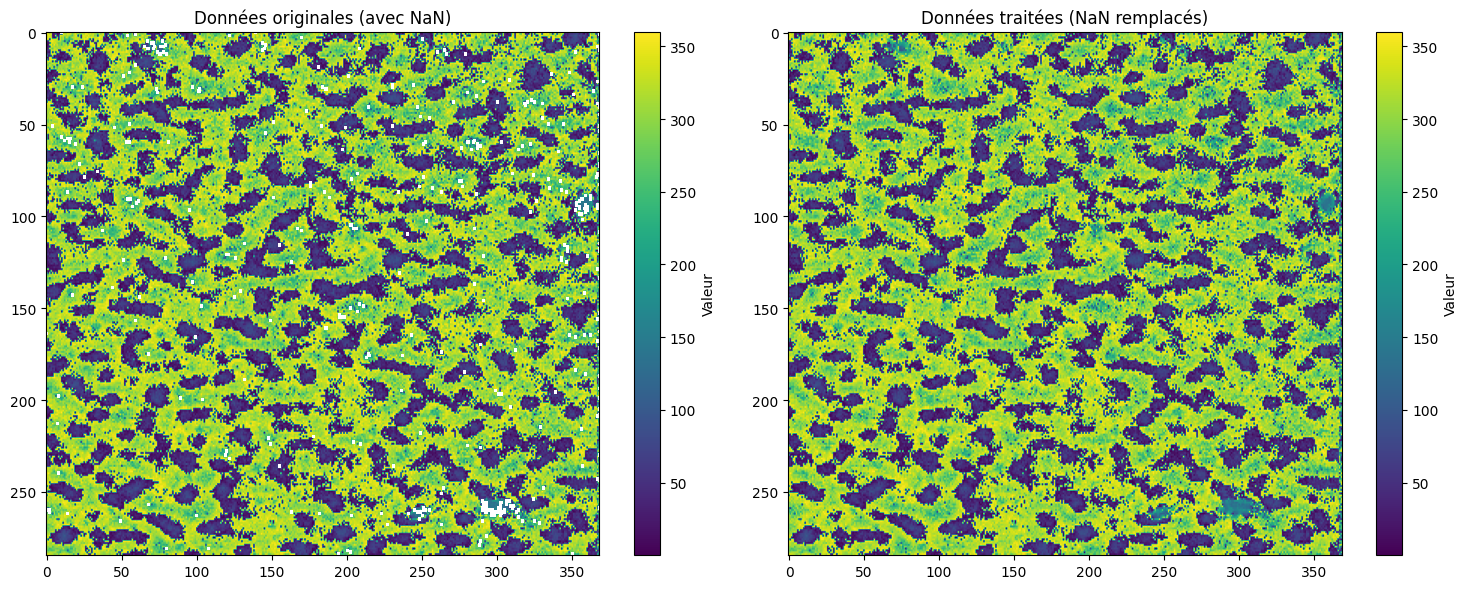

In [9]:
from scipy.ndimage import generic_filter

file_path = r"D:\Mémoire\PK221206\PK221206\MONS2-E2--ZONE1-372nm-del.map"

def replace_nan_with_local_mean(matrix):
    """Remplace les NaN par la moyenne des valeurs voisines non-NaN"""
    # Créer une copie pour éviter de modifier l'original
    result = np.copy(matrix)
    
    # Fonction pour calculer la moyenne locale
    def local_mean(window):
        window = window[~np.isnan(window)]
        return np.mean(window) if len(window) > 0 else np.nan
    
    # Trouver les positions des NaN
    nan_positions = np.where(np.isnan(matrix))
    
    # Pour chaque NaN, calculer la moyenne des 8 voisins
    for i, j in zip(*nan_positions):
        # Définir la fenêtre 3x3 autour du pixel
        i_min = max(0, i-1)
        i_max = min(matrix.shape[0], i+2)
        j_min = max(0, j-1)
        j_max = min(matrix.shape[1], j+2)
        
        window = matrix[i_min:i_max, j_min:j_max]
        mean_val = local_mean(window)
        
        # Si on a trouvé une moyenne valide, on remplace
        if not np.isnan(mean_val):
            result[i, j] = mean_val
        else:
            # Si tous les voisins sont NaN, on prend la moyenne globale
            result[i, j] = np.nanmean(matrix)
    
    return result

try:
    # Lecture des données
    data = np.loadtxt(file_path)
    
    # Traitement des NaN
    print(f"Nombre de NaN avant traitement: {np.isnan(data).sum()}")
    data_processed = replace_nan_with_local_mean(data)
    print(f"Nombre de NaN après traitement: {np.isnan(data_processed).sum()}")
    
    # Conversion en DataFrame
    df = pd.DataFrame(data_processed)
    
    # Affichage des informations
    print("\nAperçu des données traitées :")
    print(df.head())
    
    print("\nStatistiques descriptives :")
    print(df.describe())
    
    # Visualisation
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(data, cmap='viridis', aspect='auto')
    plt.colorbar(label='Valeur')
    plt.title("Données originales (avec NaN)")
    
    plt.subplot(1, 2, 2)
    plt.imshow(data_processed, cmap='viridis', aspect='auto')
    plt.colorbar(label='Valeur')
    plt.title("Données traitées (NaN remplacés)")
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Erreur lors de la lecture/traitement du fichier : {e}")

In [10]:
import os
import numpy as np
from scipy.ndimage import generic_filter

def process_zone3_files(folder_path):
    """Traite uniquement les fichiers de la Zone 3 en remplaçant les NaN et normalisant psi et delta"""
    zone3_files = [f for f in os.listdir(folder_path) if f.endswith('.map') and 'ZONE3' in f]
    
    zone3_data = {}
    
    for file_name in zone3_files:
        file_path = os.path.join(folder_path, file_name)
        
        try:
            # Lecture du fichier
            data = np.loadtxt(file_path)
            
            # Traitement des NaN
            nan_mask = np.isnan(data)
            if np.any(nan_mask):
                print(f"NaN détectés dans {file_name}: {np.sum(nan_mask)} valeurs")
                data[nan_mask] = np.nanmean(data)
                data = generic_filter(data, np.mean, size=3, mode='mirror')
            
            # Normalisation des valeurs
            if 'psi' in file_name:
                data = np.where(data < 0, 0, data)  # Forcer psi à être >= 0
                data = np.where(data > 90, 90, data)  # Forcer psi à être <= 90
            elif 'delta' in file_name:
                # Traduire delta de [0, 360] à [-180, 180]
                data = np.where(data > 180, data - 360, data)
            
            # Stockage dans le dictionnaire
            zone3_data[file_name] = data
            print(f"Fichier Zone3 traité: {file_name} | Shape: {data.shape}")
            
        except Exception as e:
            print(f"Erreur avec {file_name}: {str(e)}")
            continue
    
    return zone3_data

# Utilisation
folder_path = r"D:\Mémoire\PK221206\PK221206"
zone3_data = process_zone3_files(folder_path)

# Vérification
print("\nFichiers Zone3 traités:")
for file_name, data in zone3_data.items():
    print(f"- {file_name}: {data.shape} | Valeurs uniques: {len(np.unique(data))}")
    
# Exemple: Accès aux psi et delta pour une longueur d'onde
wl = "372nm"
psi_file = f"MONS2-E2--ZONE3-{wl}-psi.map"
delta_file = f"MONS2-E2--ZONE3-{wl}-del.map"

if psi_file in zone3_data and delta_file in zone3_data:
    print(f"\nDonnées pour {wl}:")
    print(f"Psi shape: {zone3_data[psi_file].shape}")
    print(f"Delta shape: {zone3_data[delta_file].shape}")
else:
    print(f"\nFichiers manquants pour {wl}")


NaN détectés dans MONS2-E2--ZONE3-372nm-del.map: 1295 valeurs
Fichier Zone3 traité: MONS2-E2--ZONE3-372nm-del.map | Shape: (1123, 739)
NaN détectés dans MONS2-E2--ZONE3-372nm-psi.map: 1157 valeurs
Fichier Zone3 traité: MONS2-E2--ZONE3-372nm-psi.map | Shape: (1123, 739)
NaN détectés dans MONS2-E2--ZONE3-381nm-del.map: 1494 valeurs
Fichier Zone3 traité: MONS2-E2--ZONE3-381nm-del.map | Shape: (1123, 739)
NaN détectés dans MONS2-E2--ZONE3-381nm-psi.map: 1396 valeurs
Fichier Zone3 traité: MONS2-E2--ZONE3-381nm-psi.map | Shape: (1123, 739)
NaN détectés dans MONS2-E2--ZONE3-391nm-del.map: 109 valeurs
Fichier Zone3 traité: MONS2-E2--ZONE3-391nm-del.map | Shape: (1123, 739)
NaN détectés dans MONS2-E2--ZONE3-391nm-psi.map: 44 valeurs
Fichier Zone3 traité: MONS2-E2--ZONE3-391nm-psi.map | Shape: (1123, 739)
NaN détectés dans MONS2-E2--ZONE3-400nm-del.map: 1042 valeurs
Fichier Zone3 traité: MONS2-E2--ZONE3-400nm-del.map | Shape: (1123, 739)
NaN détectés dans MONS2-E2--ZONE3-400nm-psi.map: 1384 vale

In [ ]:
import os
import numpy as np
from scipy.ndimage import generic_filter, zoom
from scipy.interpolate import interp1d

# 1. Lecture et nettoyage des fichiers de Zone 3
def process_zone3_files(folder_path):
    """Traite uniquement les fichiers de la Zone 3 en remplaçant les NaN et normalisant psi et delta"""
    zone3_files = [f for f in os.listdir(folder_path) if f.endswith('.map') and 'ZONE3' in f]
    
    zone3_data = {}
    
    for file_name in zone3_files:
        file_path = os.path.join(folder_path, file_name)
        
        try:
            # Lecture du fichier
            data = np.loadtxt(file_path)
            
            # Traitement des NaN
            nan_mask = np.isnan(data)
            if np.any(nan_mask):
                print(f"NaN détectés dans {file_name}: {np.sum(nan_mask)} valeurs")
                data[nan_mask] = np.nanmean(data)
                data = generic_filter(data, np.mean, size=3, mode='mirror')
            
            # Normalisation des valeurs
            if 'psi' in file_name:
                data = np.where(data < 0, 0, data)  # Forcer psi à être >= 0
                data = np.where(data > 90, 90, data)  # Forcer psi à être <= 90
            elif 'delta' in file_name:
                # Traduire delta de [0, 360] à [-180, 180]
                data = np.where(data > 180, data - 360, data)
            
            # Stockage dans le dictionnaire
            zone3_data[file_name] = data
            print(f"Fichier Zone3 traité: {file_name} | Shape: {data.shape}")
            
        except Exception as e:
            print(f"Erreur avec {file_name}: {str(e)}")
            continue
    
    return zone3_data

# 2. Harmonisation des dimensions
def harmonize_dimensions(data_dict, target_shape=(1123, 739)):
    harmonized = {}
    for name, data in data_dict.items():
        if data.shape != target_shape:
            zoom_factors = (target_shape[0]/data.shape[0], target_shape[1]/data.shape[1])
            harmonized[name] = zoom(data, zoom_factors, order=1)
            print(f"Redimensionné {name} de {data.shape} à {target_shape}")
        else:
            harmonized[name] = data
    return harmonized

# 3. Création des vecteurs par pixel
def create_pixel_vectors(zone3_data, target_wavelengths):
    shapes = {data.shape for data in zone3_data.values()}
    if len(shapes) != 1:
        raise ValueError(f"Dimensions incohérentes après harmonisation: {shapes}")
    height, width = next(iter(shapes))

    available_wl = sorted({float(f.split('-')[-2].replace('nm','')) 
                           for f in zone3_data.keys()})
    
    pixel_map = np.zeros((height, width, 2*len(target_wavelengths)))
    
    data_cache = {}
    for wl in available_wl:
        psi_file = f"MONS2-E2--ZONE3-{int(wl)}nm-psi.map"
        delta_file = f"MONS2-E2--ZONE3-{int(wl)}nm-del.map"
        if psi_file in zone3_data and delta_file in zone3_data:
            data_cache[wl] = (zone3_data[psi_file], zone3_data[delta_file])
    
    for i in range(height):
        for j in range(width):
            psi_vals, delta_vals, valid_wl = [], [], []
            for wl in available_wl:
                if wl in data_cache:
                    psi, delta = data_cache[wl]
                    if not (np.isnan(psi[i,j]) or np.isnan(delta[i,j])):
                        psi_vals.append(psi[i,j])
                        delta_vals.append(delta[i,j])
                        valid_wl.append(wl)
            
            if len(valid_wl) >= 2:
                psi_interp = interp1d(valid_wl, psi_vals, kind='linear',
                                      bounds_error=False, fill_value='extrapolate')(target_wavelengths)
                delta_interp = interp1d(valid_wl, delta_vals, kind='linear',
                                        bounds_error=False, fill_value='extrapolate')(target_wavelengths)
            else:
                psi_interp = np.zeros(len(target_wavelengths))
                delta_interp = np.zeros(len(target_wavelengths))
            
            pixel_map[i,j] = np.column_stack([psi_interp, delta_interp]).flatten()
    
    return pixel_map

# ------------------------
# Utilisation du script
# ------------------------

# Longueurs d’onde cibles
target_wl = np.array([
    361.5, 372.8, 381.3, 391.0, 400.8, 411.2, 425.1, 430.6, 439.7,
    450.0, 461.0, 468.9, 481.0, 492.9, 501.0, 509.6, 520.8, 533.0,
    545.5, 562.6, 572.3, 590.0, 601.5, 609.8, 633.2, 641.0, 660.4,
    675.1, 688.5, 712.2, 722.2, 742.4, 762.8, 770.5, 791.8, 812.8,
    827.7, 852.6, 871.5, 881.9, 904.4, 920.3, 952.3, 971.1, 1000.3
])

folder_path = r"D:\Mémoire\PK221206\PK221206"

# Étape 1 : lecture et traitement des fichiers Zone 3
zone3_data = process_zone3_files(folder_path)

# Étape 2 : harmonisation des tailles
print("\nHarmonisation des dimensions...")
zone3_data_harmonized = harmonize_dimensions(zone3_data)

# Étape 3 : génération des vecteurs par pixel
print("\nCréation des vecteurs pixels...")
pixel_vectors = create_pixel_vectors(zone3_data_harmonized, target_wl)

# Vérification
print("\nRésultats:")
print(f"- Dimensions de la map: {pixel_vectors.shape}")
print(f"- Nombre de longueurs d'onde: {len(target_wl)}")
print(f"- Nombre de features par pixel: {pixel_vectors.shape[2]} (attendu: {2*len(target_wl)})")

# Exemple pour un pixel
sample_pixel = pixel_vectors[50,50]
print("\nExemple de vecteur pour un pixel:")
print(f"Psi values: {sample_pixel[::2]}")
print(f"Delta values: {sample_pixel[1::2]}")


NaN détectés dans MONS2-E2--ZONE3-372nm-del.map: 1295 valeurs
Fichier Zone3 traité: MONS2-E2--ZONE3-372nm-del.map | Shape: (1123, 739)
NaN détectés dans MONS2-E2--ZONE3-372nm-psi.map: 1157 valeurs
Fichier Zone3 traité: MONS2-E2--ZONE3-372nm-psi.map | Shape: (1123, 739)
NaN détectés dans MONS2-E2--ZONE3-381nm-del.map: 1494 valeurs
Fichier Zone3 traité: MONS2-E2--ZONE3-381nm-del.map | Shape: (1123, 739)
NaN détectés dans MONS2-E2--ZONE3-381nm-psi.map: 1396 valeurs
Fichier Zone3 traité: MONS2-E2--ZONE3-381nm-psi.map | Shape: (1123, 739)
NaN détectés dans MONS2-E2--ZONE3-391nm-del.map: 109 valeurs
Fichier Zone3 traité: MONS2-E2--ZONE3-391nm-del.map | Shape: (1123, 739)
NaN détectés dans MONS2-E2--ZONE3-391nm-psi.map: 44 valeurs
Fichier Zone3 traité: MONS2-E2--ZONE3-391nm-psi.map | Shape: (1123, 739)
NaN détectés dans MONS2-E2--ZONE3-400nm-del.map: 1042 valeurs
Fichier Zone3 traité: MONS2-E2--ZONE3-400nm-del.map | Shape: (1123, 739)
NaN détectés dans MONS2-E2--ZONE3-400nm-psi.map: 1384 vale

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x0000027DFBDECEC0>>
Traceback (most recent call last):
  File "C:\Users\TimWi_x1vpvf2\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 790, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\TimWi_x1vpvf2\AppData\Local\Programs\Python\Python312\Lib\threading.py", line 1542, in enumerate
    with _active_limbo_lock:
SystemError: <built-in method __enter__ of _thread.RLock object at 0x0000027DF7F885C0> returned a result with an exception set


Fichier Zone3 traité: MONS2-E2--ZONE3-411nm-psi.map | Shape: (1123, 739)
NaN détectés dans MONS2-E2--ZONE3-425nm-del.map: 1077 valeurs
Fichier Zone3 traité: MONS2-E2--ZONE3-425nm-del.map | Shape: (1123, 739)
NaN détectés dans MONS2-E2--ZONE3-425nm-psi.map: 80 valeurs


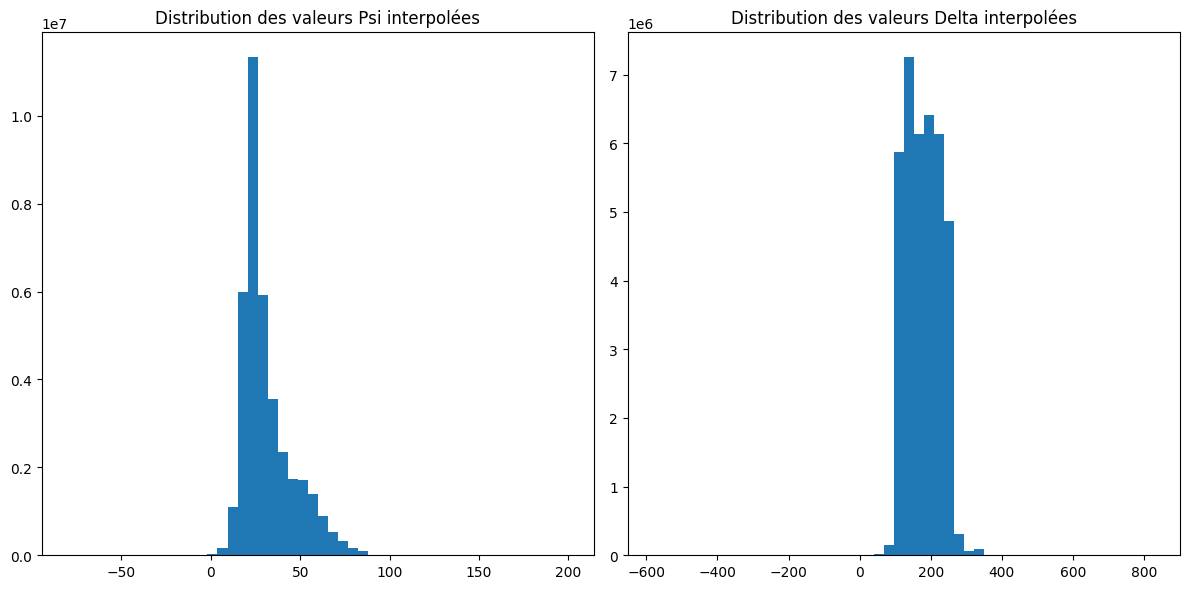

In [28]:
import matplotlib.pyplot as plt

# Visualisation des distributions
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.hist(pixel_vectors[:,:,::2].flatten(), bins=50)
plt.title('Distribution des valeurs Psi interpolées')

plt.subplot(122)
plt.hist(pixel_vectors[:,:,1::2].flatten(), bins=50)
plt.title('Distribution des valeurs Delta interpolées')

plt.tight_layout()
plt.show()

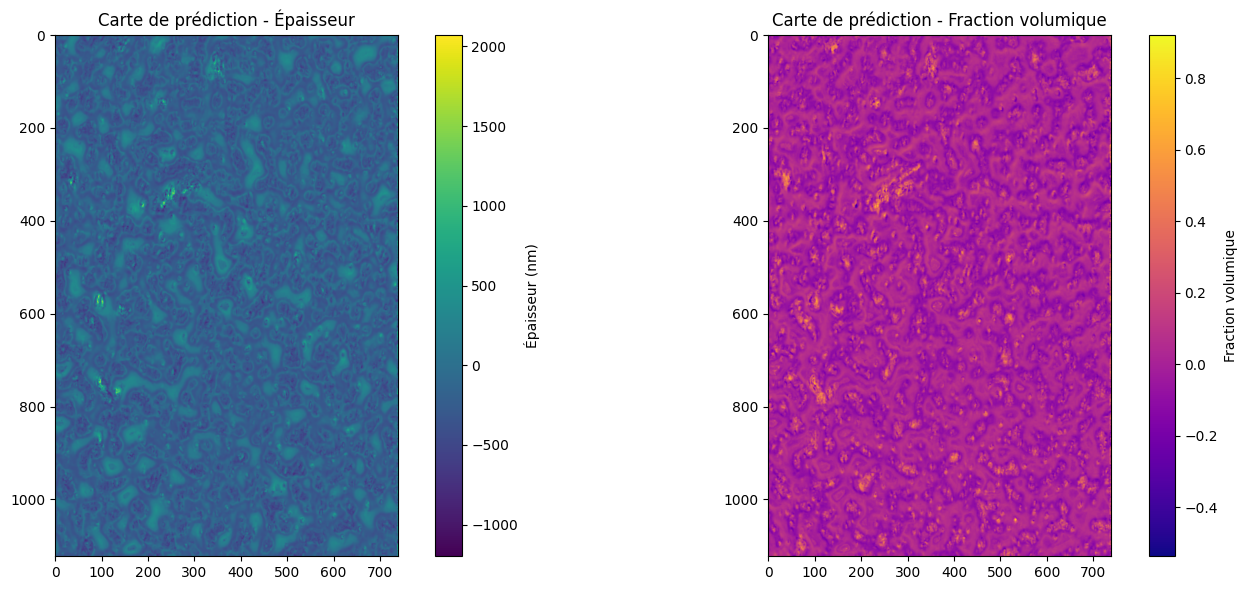


Statistiques des prédictions:
Épaisseur - Moyenne: -167.63 nm | Std: 183.78 nm
Fraction volumique - Moyenne: 0.0111 | Std: 0.0827


In [29]:
import torch
import matplotlib.pyplot as plt

# 1. Préparation des données pour le modèle
n_pixels = pixel_vectors.shape[0] * pixel_vectors.shape[1]
features = pixel_vectors.reshape(n_pixels, -1)  # Forme (n_pixels, 2*n_wavelengths)

# 2. Normalisation (identique à l'entraînement)
features_normalized = scaler_X.transform(features)  # Utilisez votre scaler d'entraînement

# 3. Conversion en tensor et prédiction
model.eval()
with torch.no_grad():
    input_tensor = torch.FloatTensor(features_normalized)
    predictions = model(input_tensor).numpy()

# 4. Inversion de la normalisation (si vous aviez normalisé y)
predictions = scaler_y.inverse_transform(predictions)  # Utilisez votre scaler_y

# 5. Reconstruction des cartes
thickness_map = predictions[:, 0].reshape(pixel_vectors.shape[0], pixel_vectors.shape[1])
vfraction_map = predictions[:, 1].reshape(pixel_vectors.shape[0], pixel_vectors.shape[1])

# 6. Visualisation
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
im1 = plt.imshow(thickness_map, cmap='viridis')
plt.colorbar(im1, label='Épaisseur (nm)')
plt.title('Carte de prédiction - Épaisseur')

plt.subplot(1, 2, 2)
im2 = plt.imshow(vfraction_map, cmap='plasma')
plt.colorbar(im2, label='Fraction volumique')
plt.title('Carte de prédiction - Fraction volumique')

plt.tight_layout()
plt.show()

# 7. Statistiques des prédictions
print("\nStatistiques des prédictions:")
print(f"Épaisseur - Moyenne: {np.nanmean(thickness_map):.2f} nm | Std: {np.nanstd(thickness_map):.2f} nm")
print(f"Fraction volumique - Moyenne: {np.nanmean(vfraction_map):.4f} | Std: {np.nanstd(vfraction_map):.4f}")

# 8. Sauvegarde des résultats (optionnel)
np.save('thickness_map.npy', thickness_map)
np.save('vfraction_map.npy', vfraction_map)